In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx

import pynwb
from pynwb import get_class
from pynwb import register_class
from pynwb.form.utils import docval, getargs, popargs, call_docval_func

import matplotlib.pyplot as plt

### Build the track in NetworkX

In [2]:
# Initialize a graph
G = nx.Graph(name='w-track')

# Add nodes to the graph
# ----------------------
# Segments
G.add_node('L', coords=[(1.6, 2.2), (1.6, 0.65)], intermediate_coords=None, kind='segment')
G.add_node('LC', coords=[(1.6, 0.65), (1.9, 0.65)], intermediate_coords=None, kind='segment')  
G.add_node('C', coords=[(1.9, 0.65), (1.9, 2.2)], intermediate_coords=None, kind='segment')  
G.add_node('RC', coords=[(1.9, 0.65), (2.2, 0.65)], intermediate_coords=None, kind='segment')  
G.add_node('R', coords=[(2.2, 0.65), (2.2, 2.2)], intermediate_coords=None, kind='segment')  
G.add_node('EH', coords=[(1.9, 0.4), (1.9, 0.65)], intermediate_coords=None, kind='segment')
# Points
G.add_node('LW', coords=(1.6, 2.2), kind='point')
G.add_node('CW', coords=(1.9, 2.2), kind='point')
G.add_node('RW', coords=(2.2, 2.2), kind='point')
G.add_node('CP', coords=(1.9, 0.65), kind='point')
G.add_node('SBD', coords=(1.9, 0.4), kind='point')
# Polygon areas
G.add_node('SB', coords=[(1.8, 0.4), (1.9, 0.4), (2.0, 0.4), (2.0, 0.0), (1.8, 0.0)], 
           interior_coords=None, kind='polygon')

# Add edges connecting the appropriate nodes
# -----------------------------------------
# Segment <-> Segment       (Segs must share a coord)
G.add_edge('L', 'LC')
G.add_edge('RC', 'R')
# Segment <-> Well (Point)  (Seg must share a coord with the well)
G.add_edge('L', 'LW')
G.add_edge('C', 'CW')
G.add_edge('R', 'RW')
# Choice Point (Point) <-> Segments  (Seg must share a coord with the choice point)
G.add_edge('CP', 'C')
G.add_edge('CP', 'LC')
G.add_edge('CP', 'RC')
G.add_edge('CP', 'EH')
# Door (Point) <-> Segment  (Segment must share a coord with the door)
G.add_edge('SBD', 'EH')
# Polygon <-> Door (Point)  (Area must share a coord with the door)
G.add_edge('SB', 'SBD')

### Plot the track topology from NetworkX

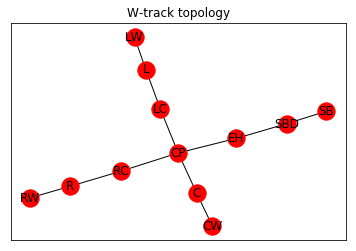

In [3]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology")
nx.draw_networkx(G, fontsize=6)
pass

### Plot geometry from NetworkX

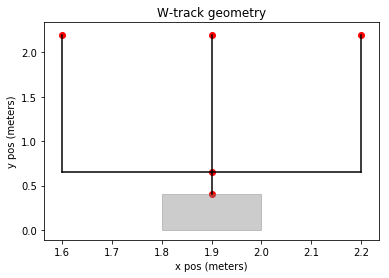

In [4]:
ax = plt.subplot(111)
plt.title('W-track geometry')
for n, attrs in list(G.nodes.data()):
    if attrs['kind']=='point':
        coord = attrs['coords']
        plt.scatter([coord[0]], [coord[1]], color='r')
    elif attrs['kind']=='segment':
        start, end = attrs['coords']
        plt.plot([start[0], end[0]], [start[1], end[1]], color='k')
    elif attrs['kind']=='polygon':
        poly = attrs['coords']
        xs = [e[0] for e in poly]
        ys = [e[1] for e in poly]
        plt.fill(xs, ys, color='grey', alpha=0.4)
    else:
        raise TypeError("Nodes must have 'kind' point, segment, or polygon.")
plt.xlabel('x pos (meters)')
plt.ylabel('y pos (meters)')
pass 

### Load extension and get Python classes for the FL_ApparatusNodes

Note that the get_class() methods turn all parameters into type list/tuple/dict/set. 
This works for Nodes, since they just have coords that we can view as a list of (x, y) 
tuples as a convention. It also works for Edges, which we can view as a list of two Nodes
as convention. However, we might want to write our own Python classes at some
point to enforce the behavior we want, instead of just using named lists for these parameters.

In [9]:
ns_path = "franklab.namespace.yaml"
pynwb.load_namespaces(ns_path)

# Node
FL_ApparatusNode = get_class('FL_ApparatusNode', 'franklab')
FL_PointNode = get_class('FL_PointNode', 'franklab')
FL_SegmentNode = get_class('FL_SegmentNode', 'franklab')
FL_PolygonNode = get_class('FL_PolygonNode', 'franklab')

# Edge
FL_ApparatusEdge = get_class('FL_ApparatusEdge', 'franklab')

### Make a Python class for FL_ApparatusGraph

As mentioned above, the get_class() method turns all parameters into type list/tuple/dict/set. For FL_ApparatusGraph, we have a nodes list and an edge list, so we could again just allow these to be named lists. However, we want to include some enforcement of properties on this graph, such as making sure all nodes are of type FL_BehavioralNode, and requiring all edges to contain only nodes in the nodes list. To do this, I will write my own Python class implementing the FL_ApparatusGraph spec.

In [15]:
@register_class('FL_ApparatusGraph', 'franklab')
class FL_ApparatusGraph(pynwb.core.NWBContainer):
    """
    Graph of FL_ApparatusNodes connected by undirected FL_ApparatusEdges.
    Represents behaviorally reachable components of an apparatus.
    """

    @docval({'name': 'name', 'type': str, 'doc': 'Name of this graph', 'default': 'FL_ApparatusGraph'},
            {'name': 'description', 'type': str, 'doc': 'A description of this graph', 'default': ''})
    def __init__(self, **kwargs):
        call_docval_func(super(FL_ApparatusGraph, self).__init__, kwargs)
        edges = []
        nodes = []

    def add_edge(self, edge):
        """
        Add an undirected edge to the edge list. Both nodes must already be in the nodes list.
        """
        if not isinstance(edge, FL_ApparatusEdge):
            raise TypeError("Edge must be of type FL_ApparatusEdge")
        if edge.nodes[0] not in nodes or edge.nodes[1] not in nodes:
            raise ValueError("Both nodes in the edge must already be in the nodes list.")
        edges.append(edge)
        
    def add_node(self, node):
        """
        Add a node to the nodes list.
        """
        if not isinstance(edge, FL_ApparatusNode):
            raise TypeError("Node must be of type FL_ApparatusNode")
        nodes.append(node)
    
    

### Load NetworkX nodes into FL_ApparatusNode objects

In [ ]:
segment_nodes = []
point_nodes = []
area_nodes = []
for n, attrs in list(G.nodes.data()):
    if attrs['kind']=='segment':
        segment_nodes.append(FL_SegmentNode(name=n, coords=attrs['coords'], 
                                            intermediate_coords=attrs['intermediate_coords']))
    elif attrs['kind']=='point':
        point_nodes.append(FL_PointNode(name=n, coords=attrs['coords']))
    elif attrs['kind']=='polygon':
        area_nodes.append(FL_PolygonNode(name=n, coords=attrs['coords'], 
                                      interior_coords=attrs['interior_coords']))
    else:
        raise TypeError('Nodes must be of type point, segment, or polygon.')

### Load NetworkX edges into FL_ApparatusEdge objects

### Create an FL_ApparatusGraph using our nodes and edges

### Save FL extensions into NWBfile

### Roundtrip the NWBfile with our graph data

### Extract graph data back out into NetworkX

In [ ]:
help(FL_SegmentNode)